In [1]:
from sympy import *
init_printing()

In [ ]:
import pandas as pd

# Load cleaned weather data
file_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/dmi_weather_data_cleaned.csv"
df = pd.read_csv(file_path, header=0, parse_dates=["time"], index_col="time")

# Rename index to "time" for clarity
df.index.name = "time"

# Ensure weather data (df) has a timezone-naive datetime index
df.index = df.index.tz_localize(None)

# Load inflow data (KarupBro)
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Rename timestamp to match weather data index
korup_parken_df.rename(columns={"timestamp": "time"}, inplace=True)

# Merge inflow data with weather data
merged_df = df.merge(korup_parken_df[["time", "KarupBro"]], on="time", how="left")

# Drop BygholmPark column if present
if "BygholmPark" in merged_df.columns:
    merged_df = merged_df.drop(columns=["BygholmPark"])

merged_df.head()

,time,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,wind_dir_past1h,wind_speed_past1h,wind_gust_always_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob,KarupBro
0,2002-01-01,-9.3,6.4,1.250000,-0.062500,-0.2,0.1,0.037500,88.708333,281.666667,6.995833,10.587302,2.2,34.0,271.0,0.0,1829.75
1,2002-01-02,-6.3,6.4,-0.837500,-1.970833,-0.1,0.0,-0.033333,77.583333,110.208333,2.695833,10.685714,0.0,0.0,805.0,328.0,7279.46
2,2002-01-03,-7.6,-1.0,-5.166667,-6.937500,-0.2,0.0,-0.100000,87.458333,158.625000,1.195833,12.360317,0.0,0.0,739.0,278.5,5261.85
3,2002-01-04,-9.3,-1.3,-6.025000,-7.950000,-0.7,-0.2,-0.333333,80.916667,221.708333,0.987500,12.968254,0.0,0.0,876.0,355.0,2951.97
4,2002-01-05,-10.6,3.7,-3.466667,-4.337500,-1.1,-0.4,-0.754167,92.458333,239.750000,1.854167,10.766667,0.1,1.0,659.0,268.5,1868.53


Epoch 1/50
600/600 [==============================] - 28s 45ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 2/50
600/600 [==============================] - 25s 41ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 3/50
600/600 [==============================] - 25s 42ms/step - loss: 0.0073 - val_loss: 0.0099
Epoch 4/50
600/600 [==============================] - 25s 41ms/step - loss: 0.0072 - val_loss: 0.0106
Epoch 5/50
600/600 [==============================] - 25s 42ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 6/50
600/600 [==============================] - 25s 42ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 7/50
600/600 [==============================] - 26s 43ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 8/50
600/600 [==============================] - 24s 40ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 9/50
600/600 [==============================] - 23s 39ms/step - loss: 0.0059 - val_loss: 0.0099
Epoch 10/50
600/600 [==============================] - 23s 39ms/step - loss: 0.005

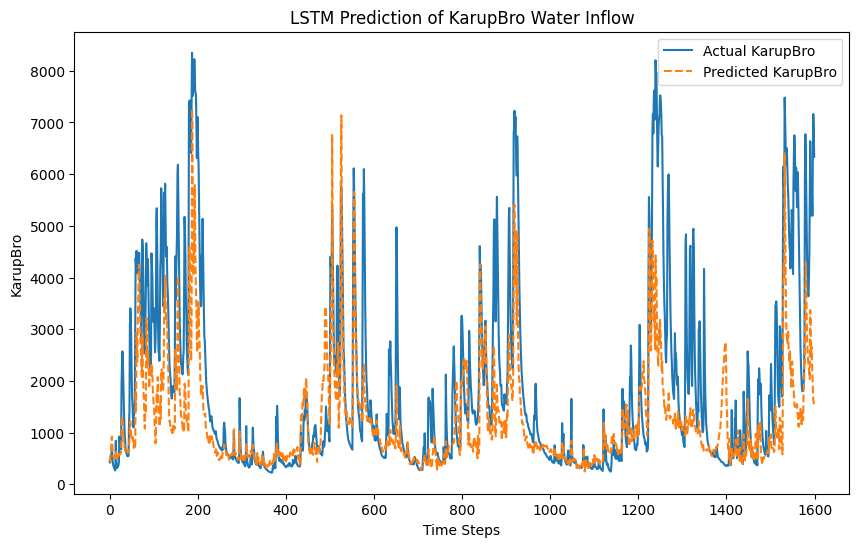

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define hyperparameters
TIME_STEPS = 30
LSTM_UNITS = 400
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 50  # Increased to allow better learning

# Preprocess data
def preprocess_data(df, time_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Ensure only numerical features
    X_scaled = scaler_X.fit_transform(df.drop(columns=["KarupBro"]).select_dtypes(include=[np.number]))
    y_scaled = scaler_y.fit_transform(df["KarupBro"].values.reshape(-1, 1))
    
    X_series, y_series = [], []
    for i in range(time_steps, len(X_scaled)):
        X_series.append(X_scaled[i - time_steps:i])
        y_series.append(y_scaled[i])
    
    return np.array(X_series), np.array(y_series), scaler_X, scaler_y


# Build LSTM model
def build_model(time_steps, features, lstm_units, learning_rate):
    model = Sequential([
        LSTM(lstm_units, return_sequences=False, input_shape=(time_steps, features)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    return model

# Prepare dataset
merged_df = merged_df.dropna()  # Ensure no missing values
X_series, y_series, scaler_X, scaler_y = preprocess_data(merged_df, TIME_STEPS)

# Split into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_series, y_series, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
FEATURES = X_series.shape[2]

# Build and train model
model = build_model(TIME_STEPS, FEATURES, LSTM_UNITS, LEARNING_RATE)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict on test data
y_pred = model.predict(X_test)
y_test_inverse = scaler_y.inverse_transform(y_test)
y_pred_inverse = scaler_y.inverse_transform(y_pred)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="Actual KarupBro")
plt.plot(y_pred_inverse, label="Predicted KarupBro", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("KarupBro")
plt.title("LSTM Prediction of KarupBro Water Inflow")
plt.legend()
plt.show()